In [ ]:
import pandas as pd
import numpy as np

from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_error, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import ElasticNet
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
df = pd.read_csv('data/player_stats.csv',  encoding='ISO-8859-1')

In [27]:
df = df.drop('marking', axis=1)

In [28]:
df.drop_duplicates(inplace=True)

In [29]:
df = df.drop('player', axis=1)

In [30]:
df

,country,height,weight,age,club,ball_control,dribbling,slide_tackle,stand_tackle,aggression,...,curve,fk_acc,penalties,volleys,gk_positioning,gk_diving,gk_handling,gk_kicking,gk_reflexes,value
0,Colombia,192,84,22,Atl. Nacional,55,43,68,73,72,...,32,34,41,33,10,11,6,7,9,$1.400.000
1,Brazil,181,80,31,Corinthians,69,70,56,58,62,...,65,62,48,46,12,15,14,8,14,$975.00
2,Germany,193,84,29,Holstein Kiel,25,12,13,16,27,...,20,15,26,16,64,74,65,68,74,$1.100.000
3,Austria,187,86,33,SK Rapid Wien,46,48,66,69,71,...,25,13,22,19,10,10,8,14,9,$650.00
4,Uruguay,191,80,23,Independiente,14,8,14,16,28,...,9,10,16,5,61,59,62,64,64,$300.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5677,Egypt,175,71,31,Liverpool,86,88,41,43,63,...,84,69,86,83,11,14,14,9,14,$99.500.000
5678,Senegal,174,69,31,FC Bayern München,86,88,38,42,75,...,77,64,75,75,7,10,10,15,14,$101.000.000
5679,Brazil,175,68,31,Paris SG,94,95,29,32,63,...,88,87,91,86,15,9,9,15,11,$99.500.000
5680,Portugal,187,83,38,Al Nassr,87,81,24,32,62,...,79,75,90,85,14,7,11,15,11,$31.000.000


In [31]:
df['value'] = df['value'].astype(str)  # Ensure values are strings
df['value'] = df['value'].str.replace(r'[^\d]', '', regex=True)  # Remove non-digits
df['value'] = pd.to_numeric(df['value'], errors='coerce')  # Convert to numbers
df['value'] = df['value'].astype('Int64')

In [32]:
df['value']

0         1400000
1           97500
2         1100000
3           65000
4           30000
          ...    
5677     99500000
5678    101000000
5679     99500000
5680     31000000
5681     10500000
Name: value, Length: 5679, dtype: Int64

In [33]:
numerical_feature = [feature for feature in df.columns if df[feature].dtype != 'O']
categorical_feature = [feature for feature in df.columns if df[feature].dtype == 'O']

In [34]:
X = df.drop(columns=['value'], axis =1)

In [35]:
X.head()

,country,height,weight,age,club,ball_control,dribbling,slide_tackle,stand_tackle,aggression,...,long_shots,curve,fk_acc,penalties,volleys,gk_positioning,gk_diving,gk_handling,gk_kicking,gk_reflexes
0,Colombia,192,84,22,Atl. Nacional,55,43,68,73,72,...,31,32,34,41,33,10,11,6,7,9
1,Brazil,181,80,31,Corinthians,69,70,56,58,62,...,68,65,62,48,46,12,15,14,8,14
2,Germany,193,84,29,Holstein Kiel,25,12,13,16,27,...,20,20,15,26,16,64,74,65,68,74
3,Austria,187,86,33,SK Rapid Wien,46,48,66,69,71,...,33,25,13,22,19,10,10,8,14,9
4,Uruguay,191,80,23,Independiente,14,8,14,16,28,...,6,9,10,16,5,61,59,62,64,64


In [36]:
y = df['value']

In [37]:
y.head()

0    1400000
1      97500
2    1100000
3      65000
4      30000
Name: value, dtype: Int64

In [38]:
num_features = X.select_dtypes(exclude = "object").columns
cat_features = X.select_dtypes(include = "object").columns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, cat_features),
        ("StandardScaler", numeric_transformer, num_features)
    ]
)

In [39]:
preprocessor

ColumnTransformer(transformers=[('OneHotEncoder', OneHotEncoder(),
                                 Index(['country', 'club'], dtype='object')),
                                ('StandardScaler', StandardScaler(),
                                 Index(['height', 'weight', 'age', 'ball_control', 'dribbling', 'slide_tackle',
       'stand_tackle', 'aggression', 'reactions', 'att_position',
       'interceptions', 'vision', 'composure', 'crossing', 'short_pass',
       'long_pass', 'acceleration', 'stamina', 'strength', 'balance',
       'sprint_speed', 'agility', 'jumping', 'heading', 'shot_power',
       'finishing', 'long_shots', 'curve', 'fk_acc', 'penalties', 'volleys',
       'gk_positioning', 'gk_diving', 'gk_handling', 'gk_kicking',
       'gk_reflexes'],
      dtype='object'))])

In [40]:
X= preprocessor.fit_transform(X)

In [41]:
X.shape

(5679, 860)

In [42]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4543, 860), (1136, 860), (4543,), (1136,))

In [43]:
def evaluated_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, mse, rmse, r2_square

In [44]:
models = {
    "LinearRegression": LinearRegression(),
    "Lasso":Lasso(),
    "Ridge": Ridge(),
    "KNeighborsRegressor":KNeighborsRegressor(),
    "DecisionTreeRegressor":DecisionTreeRegressor(),
    "RandomForestRegressor":RandomForestRegressor(),
    "AdaBoostRegressor":AdaBoostRegressor(),
    "XGBRegressor": XGBRegressor(),
    "CatBoostRegressor": CatBoostRegressor(verbose= False)
}

model_list =[]
r2_list=[]

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)


    model_train_mae, model_train_mse, model_train_rmse, model_train_r2 = evaluated_model(y_train, y_train_pred)

    model_test_mae, model_test_mse, model_test_rmse, model_test_r2 = evaluated_model(y_test, y_test_pred)


    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])


    print(f'Model performance for train \n')
    print(f'RMSE: {model_train_rmse} \n')
    print(f'MAE: {model_train_mae} \n')
    print(f'MSE: {model_train_mse} \n')
    print(f'R2: {model_train_r2} \n')

    print(f'Model performance for test \n')
    print(f'RMSE: {model_test_rmse} \n')
    print(f'MAE: {model_test_mae} \n')
    print(f'MSE: {model_test_mse} \n')
    print(f'R2: {model_test_r2} \n')

    r2_list.append(model_test_r2)

    print('='*35)
    print('\n')


LinearRegression
Model performance for train 

RMSE: 4364091.448752226 

MAE: 2038299.3138228108 

MSE: 19045294173072.305 

R2: 0.6433108321947876 

Model performance for test 

RMSE: 5972148.357309417 

MAE: 2649208.1665381556 

MSE: 35666556001713.56 

R2: 0.5340151355137586 





/Users/arpitagarwal/Desktop/coding/end-2-end ml project/venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7532116579413024.0, tolerance: 24257190640428.277
  model = cd_fast.sparse_enet_coordinate_descent(


Lasso
Model performance for train 

RMSE: 4364090.977346857 

MAE: 2038076.2871187811 

MSE: 19045290058560.242 

R2: 0.6433109092532918 

Model performance for test 

RMSE: 5976448.930295164 

MAE: 2649338.8102165763 

MSE: 35717941816426.21 

R2: 0.5333437779567173 



Ridge
Model performance for train 

RMSE: 4535154.665459488 

MAE: 2179244.32292498 

MSE: 20567627839638.96 

R2: 0.6147998560074386 

Model performance for test 

RMSE: 6286140.258910388 

MAE: 2699383.560015935 

MSE: 39515559354693.96 

R2: 0.48372776530174577 



KNeighborsRegressor
Model performance for train 

RMSE: 3096395.981954883 

MAE: 867888.7123046445 

MSE: 9587668077066.344 

R2: 0.82043767260699 

Model performance for test 

RMSE: 4499563.859825711 

MAE: 1028081.1795774648 

MSE: 20246074928649.65 

R2: 0.7354842872535315 



DecisionTreeRegressor
Model performance for train 

RMSE: 0.0 

MAE: 0.0 

MSE: 0.0 

R2: 1.0 

Model performance for test 

RMSE: 3487878.060792009 

MAE: 969320.7746478873 

M

In [48]:
import pandas as pd


model_list = []
train_rmse_list = []
train_mae_list = []
train_mse_list = []
train_r2_list = []

test_rmse_list = []
test_mae_list = []
test_mse_list = []
test_r2_list = []

for i in range(len(list(models))):
    model_name = list(models.keys())[i]
    model = list(models.values())[i]
    

    model.fit(X_train, y_train)


    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)


    model_train_mae, model_train_mse, model_train_rmse, model_train_r2 = evaluated_model(y_train, y_train_pred)
    model_test_mae, model_test_mse, model_test_rmse, model_test_r2 = evaluated_model(y_test, y_test_pred)

    model_list.append(model_name)

    train_rmse_list.append(model_train_rmse)
    train_mae_list.append(model_train_mae)
    train_mse_list.append(model_train_mse)
    train_r2_list.append(model_train_r2)

    test_rmse_list.append(model_test_rmse)
    test_mae_list.append(model_test_mae)
    test_mse_list.append(model_test_mse)
    test_r2_list.append(model_test_r2)


model_comparison_df = pd.DataFrame({
    'Model Name': model_list,
    'Train RMSE': train_rmse_list,
    'Train MAE': train_mae_list,
    'Train MSE': train_mse_list,
    'Train R²': train_r2_list,
    'Test RMSE': test_rmse_list,
    'Test MAE': test_mae_list,
    'Test MSE': test_mse_list,
    'Test R²': test_r2_list
}).sort_values(by=["Test R²"], ascending=False)

print(model_comparison_df)


/Users/arpitagarwal/Desktop/coding/end-2-end ml project/venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7532116579413024.0, tolerance: 24257190640428.277
  model = cd_fast.sparse_enet_coordinate_descent(


              Model Name    Train RMSE     Train MAE     Train MSE  Train R²  \
8      CatBoostRegressor  3.276318e+05  2.280888e+05  1.073426e+11  0.997990   
5  RandomForestRegressor  1.016556e+06  2.803546e+05  1.033387e+12  0.980646   
7           XGBRegressor  2.238909e+05  1.522740e+05  5.012715e+10  0.999061   
4  DecisionTreeRegressor  0.000000e+00  0.000000e+00  0.000000e+00  1.000000   
3    KNeighborsRegressor  3.096396e+06  8.678887e+05  9.587668e+12  0.820438   
0       LinearRegression  4.364091e+06  2.038299e+06  1.904529e+13  0.643311   
1                  Lasso  4.364091e+06  2.038076e+06  1.904529e+13  0.643311   
2                  Ridge  4.535155e+06  2.179244e+06  2.056763e+13  0.614800   
6      AdaBoostRegressor  8.325601e+06  8.138376e+06  6.931564e+13 -0.298176   

      Test RMSE      Test MAE      Test MSE   Test R²  
8  2.585866e+06  5.849460e+05  6.686705e+12  0.912638  
5  2.886112e+06  7.289609e+05  8.329644e+12  0.891173  
7  3.345900e+06  7.816507e+05  

In [49]:
cat_model = CatBoostRegressor(verbose=0)
cat_model = cat_model.fit(X_train, y_train)
y_pred = cat_model.predict(X_test)
score = r2_score(y_test, y_pred)*100
print(f"Accuracy is {score:.2f}%")

Accuracy is 91.26%


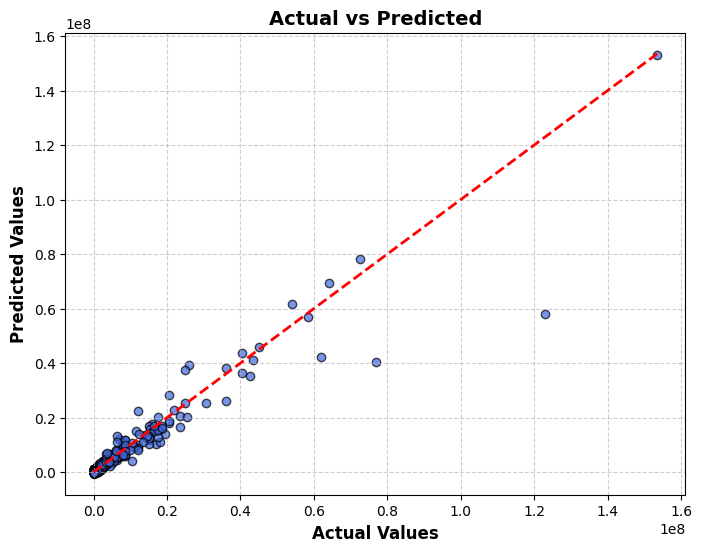

In [53]:
plt.figure(figsize=(8, 6), dpi=100)
plt.scatter(y_test, y_pred, alpha=0.7, edgecolors='k', color='royalblue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='dashed', linewidth=2)
plt.xlabel('Actual Values', fontsize=12, fontweight='bold')
plt.ylabel('Predicted Values', fontsize=12, fontweight='bold')
plt.title('Actual vs Predicted', fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


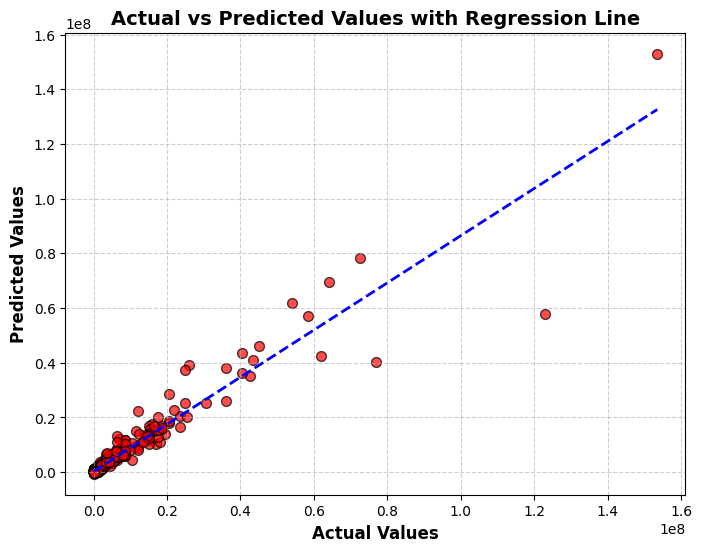

In [55]:
plt.figure(figsize=(8, 6), dpi=100)
sns.regplot(x=y_test, y=y_pred, ci=None, color='red', scatter_kws={'s': 50, 'alpha': 0.7, 'edgecolor': 'black'}, line_kws={'color': 'blue', 'lw': 2, 'ls': '--'})
plt.title('Actual vs Predicted Values with Regression Line', fontsize=14, fontweight='bold')
plt.xlabel('Actual Values', fontsize=12, fontweight='bold')
plt.ylabel('Predicted Values', fontsize=12, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [58]:
pred_df = pd.DataFrame({
    'Actual Value': y_test,
    'Predicted Value': y_pred,
    'Difference': (y_test - y_pred)
})


pred_df['Actual Value'] = pred_df['Actual Value'].round(2)
pred_df['Predicted Value'] = pred_df['Predicted Value'].round(2)
pred_df['Difference'] = pred_df['Difference'].round(2)

pred_df.style.applymap(lambda x: 'color: red' if x < 0 else 'color: green', subset=['Difference'])\
             .highlight_max(axis=0, color='lightyellow')\
             .highlight_min(axis=0, color='lightcoral')\
             .set_caption("Comparison of Actual vs Predicted Values")\
             .set_table_styles([
                 {'selector': 'th', 'props': [('background-color', 'lightblue'), ('font-weight', 'bold')]},
                 {'selector': 'td', 'props': [('font-size', '12pt'), ('font-family', 'Arial')]},
             ])

/var/folders/zg/r4nbgjbx1b50qr9vtlg77vgh0000gn/T/ipykernel_3449/1967339476.py:12: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  pred_df.style.applymap(lambda x: 'color: red' if x < 0 else 'color: green', subset=['Difference'])\


,Actual Value,Predicted Value,Difference
1132,20500000,17873319.770000,2626680.230000
935,32500,63967.430000,-31467.430000
1783,72500,742328.620000,-669828.620000
3767,87500,719190.170000,-631690.170000
4964,9000,46899.570000,-37899.570000
2632,30000,51165.940000,-21165.940000
1435,4500,44335.190000,-39835.190000
1789,25000,-86324.920000,111324.920000
2526,57500,110024.250000,-52524.250000
625,40000,-34419.280000,74419.280000
